# Imports

In [1]:
import os   # For path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Config GPU env

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14447895266319539147
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3758523924940122139
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Def NN

## Training options

In [3]:
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights.hdf5", save_best_only=True, verbose =1)

## Create a 1D convnet based on the practice lesson for time series analysis

In [4]:
def make_1d_convnet(out_type,window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    # Defining input shape of the first layer based on desired output type
    if out_type == 'xyz':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    if out_type == 'rot':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    return model

## Create input and output format from raw data

In [5]:
def make_timeseries_instances(out_type,timeseries, window_size, nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    if out_type == 'xyz':
        X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
        for coord in range(3):
            np.roll(X[:,coord + 10],1) # Move xyz coordinates to the past
        np.delete(X,0,0)
    
    # We have 3 output signal: x, y and z position    
        y = timeseries[window_size:,-11:-8]
        np.delete(y,0,0)
        
    if out_type == 'rot':
        temp_arr=timeseries[:, np.r_[:10, 14:18]] # Load sensor data and orientation reference to input
        X = np.atleast_3d(np.array([temp_arr[start:start+window_size,:nb_inputs] for start in range(0,temp_arr.shape[0]-window_size)]))
        for coord in range(4):
            np.roll(X[:,coord + 10],1) # Move orientation coordinates to the past
        np.delete(X,0,0)
    
    # We have 4 output signal: Qx, Qy, Qz and Qw orientation    
        y = timeseries[window_size:,-7:-3]
        np.delete(y,0,0)
        
    return X,y

## Train the network on timeseries

In [6]:
def evalute_timeseries(out_type,timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    
    # Define in and output size based on output type
    if out_type == 'xyz':
        nb_inputs = nb_series - 8 # Only 12 inputs (previous x,y,z position is an input now)
        nb_outputs = 3
    if out_type == 'rot':
        nb_inputs = nb_series - 7 # Only 13 inputs (previous Qx,Qy,Qz and Qw orientation is an input now)
        nb_outputs = 4
    
    # Initialize model
    model= make_1d_convnet(out_type,window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    # Fill and split the input and output variables
    X,y = make_timeseries_instances(out_type,timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    # Load the best model for plotting
    bestmodel = load_model("CNN_weights.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    # Plot the results based on output type
    if out_type == 'xyz':
        # Plot predicted x vs target x
        plt.figure(0)
        plt.plot(preds[:,0],color = 'green', label = 'x pred')
        plt.plot(targets[:,0],color = 'red', label = 'x targ')
    
        # Plot predicted z vs target z
        plt.figure(1)
        plt.plot(preds[:,2],color = 'blue', label = 'z pred')
        plt.plot(targets[:,2],color = 'yellow', label = 'z targ')
    
        # Plot the predicted route vs original route on x-z plane
        plt.figure(2)
        plt.plot(preds[:,0],preds[:,2], label = 'xz pred')
        plt.plot(targets[:,0],targets[:,2], label = 'xz targ')
        
    if out_type == 'rot':
        plt.figure(0,figsize = (15,5))
        plt.plot(preds[:,0],color = 'red', label = 'Qx pred')
        plt.plot(targets[:,0],color = 'green', label = 'Qx targ')
        
        plt.figure(1,figsize = (15,5))
        plt.plot(preds[:,1],color = 'red', label = 'Qy pred')
        plt.plot(targets[:,1],color = 'green', label = 'Qy targ')
        
        plt.figure(2,figsize = (15,5))
        plt.plot(preds[:,2],color = 'red', label = 'Qz pred')
        plt.plot(targets[:,2],color = 'green', label = 'Qz targ')
        
        plt.figure(3,figsize = (15,5))
        plt.plot(preds[:,3],color = 'red', label = 'Qw pred')
        plt.plot(targets[:,3],color = 'green', label = 'Qw targ')

# Hyperas functions
## Input data processor

In [7]:
def data(timeseries): 
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 8 #only 12 inputs (previous x,y,z position is an input now)
    window_size = 20
    
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.15  * nb_samples)
    valid_size = int(0.15 * nb_samples)
    
    x_train, x_valid, x_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(x_train[:,inpt])
        x_train[:,inpt] = scaler.transform(x_train[:,inpt])
        x_valid[:,inpt] = scaler.transform(x_valid[:,inpt])
        x_test[:,inpt] = scaler.transform(x_test[:,inpt])
        
    return x_train, y_train, x_valid, y_valid, x_test, y_test

## Create a 1D CNN

In [8]:
def create_model(x_train, y_train, x_valid, y_valid, x_test, y_test):
    # Modifyable hyperparameters
    n_layer1 = {{choice([128, 256, 512])}}
    n_layer2 = {{choice([128, 256, 512])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([16, 31, 64])}}
    
    # Constant parameters
    window_size = 20
    filter_length = 5
    nb_outputs=3
    
    # Creating model
    model = Sequential()
    model.add(Conv1D(filters = n_layer1, kernel_size = filter_length, activation = 'relu', 
                   input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = n_layer2, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optim, metrics = ['mae'])
    
    # Training model
    result = model.fit(x_train, y_train,
              batch_size = n_batch,
              epochs = 150,
              verbose = 2,
              validation_data = (x_valid, y_valid),
              callbacks = [checkpointer,early_stopping],
              shuffle = True)
    
    # Result output
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

# Load data file

In [9]:
df = pd.read_csv('PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [10]:
df.head(2)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.02,0.001,1.0,0.0,0.0,0.0


# Set hyperparameters

In [11]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

# Train NN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             264       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 375
Trainable params: 375
Non-trainable params: 0
_________________________________________________________________
Train on 382

 - 1s - loss: 3.0584e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0011 - val_mean_absolute_error: 0.0211

Epoch 00039: val_loss did not improve from 0.00094
Epoch 40/500
 - 1s - loss: 3.0729e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0014 - val_mean_absolute_error: 0.0249

Epoch 00040: val_loss did not improve from 0.00094
Epoch 41/500
 - 1s - loss: 2.9693e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0014 - val_mean_absolute_error: 0.0250

Epoch 00041: val_loss did not improve from 0.00094
Epoch 42/500
 - 1s - loss: 2.9245e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0017 - val_mean_absolute_error: 0.0261

Epoch 00042: val_loss did not improve from 0.00094
Epoch 43/500
 - 1s - loss: 2.8112e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0012 - val_mean_absolute_error: 0.0223

Epoch 00043: val_loss did not improve from 0.00094
Epoch 44/500
 - 1s - loss: 2.8409e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0015 - val_mean_absolute_error: 0.0265

Epoch 00044: val_loss did 

 - 1s - loss: 1.4445e-04 - mean_absolute_error: 0.0084 - val_loss: 5.9169e-04 - val_mean_absolute_error: 0.0167

Epoch 00084: val_loss did not improve from 0.00050
Epoch 85/500
 - 1s - loss: 1.3753e-04 - mean_absolute_error: 0.0081 - val_loss: 5.3946e-04 - val_mean_absolute_error: 0.0171

Epoch 00085: val_loss did not improve from 0.00050
Epoch 86/500
 - 1s - loss: 1.4296e-04 - mean_absolute_error: 0.0082 - val_loss: 6.7395e-04 - val_mean_absolute_error: 0.0170

Epoch 00086: val_loss did not improve from 0.00050
Epoch 87/500
 - 1s - loss: 1.4568e-04 - mean_absolute_error: 0.0084 - val_loss: 5.7631e-04 - val_mean_absolute_error: 0.0163

Epoch 00087: val_loss did not improve from 0.00050
Epoch 88/500
 - 1s - loss: 1.4257e-04 - mean_absolute_error: 0.0082 - val_loss: 4.8495e-04 - val_mean_absolute_error: 0.0145

Epoch 00088: val_loss improved from 0.00050 to 0.00048, saving model to CNN_weights.hdf5
Epoch 89/500
 - 1s - loss: 1.3891e-04 - mean_absolute_error: 0.0082 - val_loss: 4.4434e-04


Epoch 00129: val_loss did not improve from 0.00036
Epoch 130/500
 - 1s - loss: 1.1795e-04 - mean_absolute_error: 0.0075 - val_loss: 4.8606e-04 - val_mean_absolute_error: 0.0151

Epoch 00130: val_loss did not improve from 0.00036
Epoch 131/500
 - 1s - loss: 1.0244e-04 - mean_absolute_error: 0.0069 - val_loss: 6.2810e-04 - val_mean_absolute_error: 0.0189

Epoch 00131: val_loss did not improve from 0.00036
Epoch 132/500
 - 1s - loss: 1.0387e-04 - mean_absolute_error: 0.0069 - val_loss: 3.7269e-04 - val_mean_absolute_error: 0.0138

Epoch 00132: val_loss did not improve from 0.00036
Epoch 133/500
 - 1s - loss: 9.7349e-05 - mean_absolute_error: 0.0067 - val_loss: 3.9389e-04 - val_mean_absolute_error: 0.0132

Epoch 00133: val_loss did not improve from 0.00036
Epoch 134/500
 - 1s - loss: 9.4483e-05 - mean_absolute_error: 0.0065 - val_loss: 4.3099e-04 - val_mean_absolute_error: 0.0149

Epoch 00134: val_loss did not improve from 0.00036
Epoch 135/500
 - 1s - loss: 1.1385e-04 - mean_absolute_err

 - 1s - loss: 8.2279e-05 - mean_absolute_error: 0.0061 - val_loss: 2.9760e-04 - val_mean_absolute_error: 0.0116

Epoch 00175: val_loss did not improve from 0.00027
Epoch 176/500
 - 1s - loss: 8.3426e-05 - mean_absolute_error: 0.0061 - val_loss: 3.3369e-04 - val_mean_absolute_error: 0.0120

Epoch 00176: val_loss did not improve from 0.00027
Epoch 177/500
 - 1s - loss: 8.7222e-05 - mean_absolute_error: 0.0062 - val_loss: 5.0066e-04 - val_mean_absolute_error: 0.0162

Epoch 00177: val_loss did not improve from 0.00027
Epoch 178/500
 - 1s - loss: 8.6586e-05 - mean_absolute_error: 0.0062 - val_loss: 2.9274e-04 - val_mean_absolute_error: 0.0116

Epoch 00178: val_loss did not improve from 0.00027
Epoch 179/500
 - 1s - loss: 8.6403e-05 - mean_absolute_error: 0.0061 - val_loss: 3.1214e-04 - val_mean_absolute_error: 0.0125

Epoch 00179: val_loss did not improve from 0.00027
Epoch 180/500
 - 1s - loss: 8.0642e-05 - mean_absolute_error: 0.0060 - val_loss: 3.4327e-04 - val_mean_absolute_error: 0.012


Epoch 00220: val_loss did not improve from 0.00024
Epoch 221/500
 - 1s - loss: 7.3711e-05 - mean_absolute_error: 0.0056 - val_loss: 2.8771e-04 - val_mean_absolute_error: 0.0113

Epoch 00221: val_loss did not improve from 0.00024
Epoch 222/500
 - 1s - loss: 7.6456e-05 - mean_absolute_error: 0.0058 - val_loss: 3.0411e-04 - val_mean_absolute_error: 0.0125

Epoch 00222: val_loss did not improve from 0.00024
Epoch 223/500
 - 1s - loss: 8.1623e-05 - mean_absolute_error: 0.0060 - val_loss: 2.7225e-04 - val_mean_absolute_error: 0.0117

Epoch 00223: val_loss did not improve from 0.00024
Epoch 224/500
 - 1s - loss: 8.0467e-05 - mean_absolute_error: 0.0059 - val_loss: 2.4599e-04 - val_mean_absolute_error: 0.0108

Epoch 00224: val_loss did not improve from 0.00024
Epoch 225/500
 - 1s - loss: 6.9076e-05 - mean_absolute_error: 0.0054 - val_loss: 2.6717e-04 - val_mean_absolute_error: 0.0114

Epoch 00225: val_loss did not improve from 0.00024
Epoch 226/500
 - 1s - loss: 7.1099e-05 - mean_absolute_err


Epoch 00266: val_loss improved from 0.00023 to 0.00022, saving model to CNN_weights.hdf5
Epoch 267/500
 - 1s - loss: 7.8009e-05 - mean_absolute_error: 0.0057 - val_loss: 2.7397e-04 - val_mean_absolute_error: 0.0120

Epoch 00267: val_loss did not improve from 0.00022
Epoch 268/500
 - 1s - loss: 7.0552e-05 - mean_absolute_error: 0.0054 - val_loss: 3.0463e-04 - val_mean_absolute_error: 0.0119

Epoch 00268: val_loss did not improve from 0.00022
Epoch 269/500
 - 1s - loss: 6.3400e-05 - mean_absolute_error: 0.0052 - val_loss: 2.9340e-04 - val_mean_absolute_error: 0.0115

Epoch 00269: val_loss did not improve from 0.00022
Epoch 270/500
 - 1s - loss: 6.7475e-05 - mean_absolute_error: 0.0052 - val_loss: 3.2638e-04 - val_mean_absolute_error: 0.0124

Epoch 00270: val_loss did not improve from 0.00022
Epoch 271/500
 - 1s - loss: 5.7823e-05 - mean_absolute_error: 0.0048 - val_loss: 2.1802e-04 - val_mean_absolute_error: 0.0105

Epoch 00271: val_loss improved from 0.00022 to 0.00022, saving model to


Epoch 00312: val_loss did not improve from 0.00021
Epoch 313/500
 - 1s - loss: 5.7984e-05 - mean_absolute_error: 0.0048 - val_loss: 2.3212e-04 - val_mean_absolute_error: 0.0104

Epoch 00313: val_loss did not improve from 0.00021
Epoch 314/500
 - 1s - loss: 5.7561e-05 - mean_absolute_error: 0.0048 - val_loss: 2.4362e-04 - val_mean_absolute_error: 0.0108

Epoch 00314: val_loss did not improve from 0.00021
Epoch 315/500
 - 1s - loss: 5.9846e-05 - mean_absolute_error: 0.0049 - val_loss: 2.8170e-04 - val_mean_absolute_error: 0.0116

Epoch 00315: val_loss did not improve from 0.00021
Epoch 316/500
 - 1s - loss: 5.5842e-05 - mean_absolute_error: 0.0047 - val_loss: 2.1572e-04 - val_mean_absolute_error: 0.0102

Epoch 00316: val_loss did not improve from 0.00021
Epoch 317/500
 - 1s - loss: 5.7869e-05 - mean_absolute_error: 0.0049 - val_loss: 2.4172e-04 - val_mean_absolute_error: 0.0108

Epoch 00317: val_loss did not improve from 0.00021
Epoch 318/500
 - 1s - loss: 5.8109e-05 - mean_absolute_err

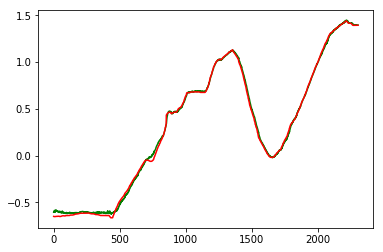

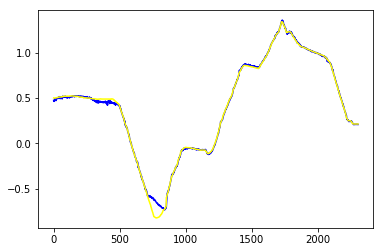

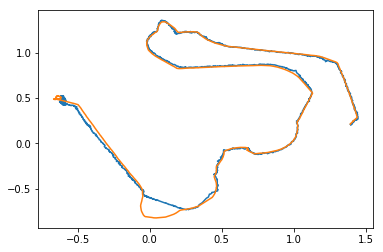

In [12]:
#use 'xyz' or 'rot' to choose output
evalute_timeseries('xyz',df,window_size,filter_length,nb_filter, epochs, batch_size)

# Draw xz position prediction with the model (previous position is the reference data)

In [13]:
# Predict with reference dataset
X,y = make_timeseries_instances('xyz',df, window_size,nb_inputs=13)
model = load_model("CNN_weights_abs.hdf5")
y_pred = model.predict(X)
plt.figure(0)
plt.plot(y_pred[:,0],y_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

OSError: Unable to open file (unable to open file: name = 'CNN_weights_abs.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Draw xz position prediction with the model (previous position is predicted)

In [ ]:
# Predict with calculated data
newX=X
print(newX.shape)
print(y.shape)

newy_pred=np.empty(y.shape)
for index in range(y.shape[0]-1):
    if index > 0:
        temp=newX[index,-1]
        newX[index]=np.roll(newX[index-1],-1, axis=0)
        newX[index,-1]=temp
        for coord in range(3):  
            newX[index,-1,coord+10]=newy_pred[index,coord]
    tmp=np.empty((1,20,13))
    tmp[0]=newX[index]
    newy_pred[index]=model.predict(tmp)
    
plt.figure(0)
plt.plot(newy_pred[:,0],newy_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

# Hyperas optimization

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# main hyperopt part
# az algoritmus lehet:
# -- random.suggest -> random search
# -- tpe.suggest -> tree parsen estimator
best_run, best_model = optim.minimize(model=create_model,
                                          data=data(df),
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='CNN_Mark')
#x_train, y_train, x_valid, y_valid, x_test, y_test = data(timeData)
#print("Evalutation of best performing model:")
#print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
